# Building CNN Classifier to Identify Microbial Composition of Metagenomic Samples

## Background: 
Genome Sequencing has become a vital part for research in microbiology. With the advent of illumina's NGS technologies, there has been a rise in bioinformatic workflows to understand the large influx of data that comes with it. These workflows usually comprise of using several different bioinformatic tools to produce abundance tables which will be used for downstream analysis. Unfortunately, this method is costly and does not give any glimpse into relationships between taxonomic classification and genome composition. In other words, we are not able to tell what part of the genome is used to make these classifications, that are done by other taxonomic classification tools such as kraken or kaiju. 
## Objective: 
To investigate if we can use deep learning to create a novel tool that can predict microbial composition of shotgun metagenomic samples using only the raw fastq file produced from Illumina NGS technology. Once composition of samples are classified we will open up our "black box" to evaluate which part of the genome is being used to make the classifications. This way we can gain insight into any evolutionary relationships that might have otherwise been unknown. 

In [6]:
#-------Creating Dataframe to download metagenome sequences from HMP website, https://hmpdacc.org/HMASM/

import pandas as pd
import numpy as np

HMP_df = pd.read_csv("~/Desktop/DeepLearningMicrobiome/sourmash_resources/HMASM.csv")
HMP_df.columns = [c.replace(' ', '_') for c in HMP_df.columns] # replaces spaces with underscore in column names
url_paths = 'https://downloads.hmpdacc.org'+HMP_df['Reads_file_location'].astype(str)

# This portion is for creating a list of urls that I can wget using multiple threads with bash script
url_paths = np.asarray(url_paths).astype(str).tolist()
with open("List_of_URLS", "w") as u:
    for link in url_paths:
        u.write(link+"\n")

In [5]:
HMP_df.head()

,SRS_ID,Body_Site,Reads_file_location,Reads_MD5,Reads_File_Size,Assembly_file_location,Assembly_MD5,Assembly_File_Size,Community
0,SRS011263,anterior_nares,/data/Illumina/anterior_nares/SRS011263.tar.bz2,30784966e7148842e5b05068efda2d55,30630950,/data/HMASM/PGAs/anterior_nares/SRS011263.scaf...,28f220153952e35ee3c547e783fabb8b,16143,oral
1,SRS046973,anterior_nares,/data/Illumina/anterior_nares/SRS046973.tar.bz2,8e27282b91e9c81a369c60ceba15cab9,54134873,/data/HMASM/PGAs/anterior_nares/SRS046973.scaf...,0d286e235bf5df37f786cd33b73d5fd4,89164,oral
2,SRS024567,anterior_nares,/data/Illumina/anterior_nares/SRS024567.tar.bz2,9eccc489c9f8f98170365ba3ba830d47,25654232,/data/HMASM/PGAs/anterior_nares/SRS024567.scaf...,3b3ddd1099df06395410a7feafcd4456,13607,oral
3,SRS017451,anterior_nares,/data/Illumina/anterior_nares/SRS017451.tar.bz2,9fa59ed275cf19d36568bc19dfc659bb,78565926,/data/HMASM/PGAs/anterior_nares/SRS017451.scaf...,0d9f410914a9c978400298c5c1afd67a,463653,oral
4,SRS015640,anterior_nares,/data/Illumina/anterior_nares/SRS015640.tar.bz2,595baf36d8b3dcdd21149b3086ccbbee,18415433,/data/HMASM/PGAs/anterior_nares/SRS015640.scaf...,6a352b0685ec954535dee0b5d38a1f3c,53695,oral


### Downloading Sequences from HMP Website

In [1]:
# ------------------------Only 3 sequences are downloaded from list as an example -------------------------
import shutil
import os
import requests
import wget

%cd /home/kia/Desktop/DeepLearningMicrobiome/
path = "/home/kia/Desktop/DeepLearningMicrobiome/sourmash_resources/"
current_path = "/home/kia/Desktop/DeepLearningMicrobiome/"

# Downloads Metagenomes and transfers them to another file (basic python version)
for i in range(0,3):
    link = url_paths[i]
    if link.find('/'): 
        tarfile_name = link.rsplit('/', 1)[1] # finds first string after last forward slash
    print("\nDownloading: ", link); print("file name: ", tarfile_name)
    wget.download(link, tarfile_name)
    tarfile_path = os.path.join(path, tarfile_name) # creates a destination pathway
    current_tarfile_path = os.path.join(current_path, tarfile_name)
    shutil.move(current_tarfile_path, tarfile_path) # moves file downloaded from one directory to another


ModuleNotFoundError: No module named 'wget'

In [3]:
%cd /home/kia/Desktop/DeepLearningMicrobiome/sourmash_resources/

/home/kia/Desktop/DeepLearningMicrobiome/sourmash_resources


### Option to download Metagenome using Multithreading 

In [2]:
# Method to Multithread Metagenome download using GNU parallel and wget
'''
%%bash
# Downloading metagenomes (need to have GNU parallel downloaded and put into PATH)
mkdir Metagenomes 
cd Metagenomes
cat ../List_of_URLS | parallel --verbose --tmpdir ~/Desktop/DeepLearningMicrobiome/ -j0 wget {} # downloading sequences using all available cores
echo "Download Complete..."
'''

'\n%%bash\n# Downloading metagenomes (need to have GNU parallel downloaded and put into PATH)\nmkdir Metagenomes \ncd Metagenomes\ncat ../List_of_URLS | parallel --verbose --tmpdir ~/Desktop/DeepLearningMicrobiome/ -j0 wget {} # downloading sequences using all available cores\necho "Download Complete..."\n'

The cell below is a script that is meant to allow sourmash software to create signatures. Sourmash is a bioinformatics software that allows for comparison of large genomic datasets by creating kmer signatures of each genome. These kmer signatures are MinHash data structures that are often used in datamining techniques to discover any novel patterns, or make comparisons between large data sets. The beauty of the sourmash tool is that we can directly compare metagenomes strictly based on kmer composition in a fast and easy manner, without using an alignment tool (which takes a significantly longer amount of time). 

In [ ]:
#To use sourmash on .tar.bz2 files we need to create a python script called "sketch-tar.py" 
#and pipe it into the sourmash sketch command. This command is what allows us to make our kmer signatures. 
'''
# sketch-tar.py
### Make this into a script which can be used on CLI or make it into a function
#! /usr/bin/env python3
import tarfile
import sys

BUFSIZE=1024*1024*10

##### using https://docs.python.org/3/library/tarfile.html

with tarfile.open(sys.argv[1], "r:bz2") as tf:
    for m in tf.getmembers():
        fp = tf.extractfile(m)
        if fp is None:
            print(f"skipping {m}", file=sys.stderr)
            continue
        else:
            print(f"reading {m}", file = sys.stderr)
        data = fp.read(BUFSIZE)
        while data:
            sys.stdout.write(data.decode('utf-8'))
            data = fp.read(BUFSIZE)
'''

### Making kmer signatures using sourmash software
This cell is to run the sourmash sketch command in parallel, using all available CPU's. 

In [ ]:
%%bash
cd ~/Desktop/DeepLearningMicrobiome/sourmash_resources/
ls *.tar.bz2 | parallel -j0 --verbose --tmpdir /home/kia/Desktop/DeepLearningMicrobiome/signature/ 'python3 sketch-tar.py {} | sourmash sketch dna - -o {}.sig --merge {}'

### Visualizing the Data 
After creating our kmer signatures, we need to see if our dataset will be easily classifiable. To do this we use a Spearman Correlation to see if our samples cluster into distinct groups. Ideally we are hoping to see 4 distinct clusters that are grouped together by the microbial environment that the samples were taken from. These four groups consist of: oral, gut, skin, vagina environments. 

In [ ]:
%%bash
sourmash compare *.sig -o compare_demo # using entire set

Populating the interactive namespace from numpy and matplotlib
/home/kia/Desktop/DeepLearningMicrobiome/sourmash_resources


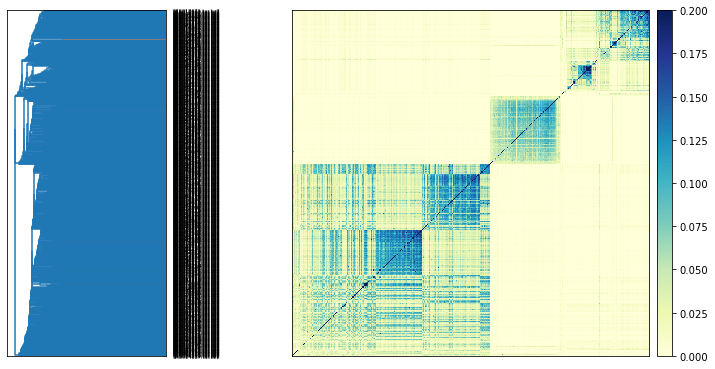

In [4]:
%pylab inline
%cd ~/Desktop/DeepLearningMicrobiome/sourmash_resources/
%pwd
# import the `fig` module from sourmash:
from sourmash import fig
matrix, labels = fig.load_matrix_and_labels('compare_demo')
f, reordered_labels, reordered_matrix = fig.plot_composite_matrix(matrix, labels, vmin=0, vmax = 0.20)
#plt.savefig("Sourmash_Matrix.jpg")

As we can see, we do have an extremely large dataset, which is displayed by the dendogram to the left side of the matrix. In total our dataset is comprised of 750 metagenomes. Based on the correlation matrix above we do see that our samples do cluster into 4 distinct communities. 

### Using Sourmash Gather command to get a list of Taxa that I can use for Training CNN
The next task is to come up with a well annotated list of sequences that can be used for training our CNN. To do this we use another function from the sourmash software called "gather". Sourmash's gather command uses the greedy algorithm to iteratively choose a list of sequences that have the largest overlap of kmers to our query sequence. The query sequences are, in this case, the metagenomes that we downloaded from HMP website. In the figure below we see a visual representation of how the sourmash gather command chooses its list of sequences based on kmer overlap. 

In [ ]:
%%bash
sourmash gather SRS014575.tar.bz2.sig /mnt/HDD/kia/missing_tar_forCNN/gtdb-rs207.genomic.k31.lca.json.gz -o SRS014575.tar.bz2.sig.csv

In [7]:
# Data wrangling to make plot Labels look cleaner
%cd /home/kia/Desktop/DeepLearningMicrobiome/sourmash_resources/
def gatherDF_cleanUp(gather_df):
    gather_df[['Name', 'junk']] = gather_df['name'].str.split(',',expand=True)
    gather_df[['Name', 'Strain']] = gather_df['Name'].str.split('strain=',expand=True)
    gather_df=gather_df.drop('junk', axis=1)
    gather_df=gather_df.drop('Strain', axis=1)
    return gather_df

/home/kia/Desktop/DeepLearningMicrobiome/sourmash_resources


In [4]:
sourmashGather_demoDF = pd.read_csv("SRS014575.tar.bz2.sig.csv")
sourmashGather_demoDF = gatherDF_cleanUp(sourmashGather_demoDF)
sourmashGather_demoDF.head()

,intersect_bp,f_orig_query,f_match,f_unique_to_query,f_unique_weighted,average_abund,median_abund,std_abund,name,filename,md5,f_match_orig,unique_intersect_bp,gather_result_rank,remaining_bp,query_filename,query_name,query_md5,query_bp,Name
0,1344000,0.015840,0.639695,0.015840,0.015840,NaN,NaN,NaN,GCF_900654165.1 Neisseria flavescens strain=N1...,/mnt/HDD/kia/HMP_reference/gtdb-rs207.genomic-...,9e2f71ef359430d825b98076799ecf08,0.639695,1344000,0,36748000,NaN,SRS014575.tar.bz2,c18cbe70,84850000,GCF_900654165.1 Neisseria flavescens
1,1248000,0.014708,0.589210,0.014673,0.014673,NaN,NaN,NaN,GCF_003252755.1 Haemophilus parainfluenzae str...,/mnt/HDD/kia/HMP_reference/gtdb-rs207.genomic-...,3e8fd94fed6765b59ed6454114bdcb94,0.590629,1245000,1,35503000,NaN,SRS014575.tar.bz2,c18cbe70,84850000,GCF_003252755.1 Haemophilus parainfluenzae
2,957000,0.011279,0.524176,0.011243,0.011243,NaN,NaN,NaN,GCF_000148585.2 Streptococcus mitis NCTC 12261...,/mnt/HDD/kia/HMP_reference/gtdb-rs207.genomic-...,132bcfa0362d0f418241e6dc4c1f77c0,0.525824,954000,2,34549000,NaN,SRS014575.tar.bz2,c18cbe70,84850000,GCF_000148585.2 Streptococcus mitis NCTC 12261
3,811000,0.009558,0.365550,0.009004,0.009004,NaN,NaN,NaN,GCF_006384255.1 Haemophilus sp. SZY H1 strain=...,/mnt/HDD/kia/HMP_reference/gtdb-rs207.genomic-...,0dbba7d5e17d7222421400a0f13ae34c,0.388038,764000,3,33785000,NaN,SRS014575.tar.bz2,c18cbe70,84850000,GCF_006384255.1 Haemophilus sp. SZY H1
4,757000,0.008922,0.331577,0.008898,0.008898,NaN,NaN,NaN,GCF_001808955.1 Rothia sp. HMSC078H08 strain=H...,/mnt/HDD/kia/HMP_reference/gtdb-rs207.genomic-...,74fd6131ca3bd446231e30bd4c48bf46,0.332455,755000,4,33030000,NaN,SRS014575.tar.bz2,c18cbe70,84850000,GCF_001808955.1 Rothia sp. HMSC078H08


### Formatting Gather DF Plots
In the figure below we see a list of reference genomes that are generated from using the sourmash gather command on only 1 metagenome. The database that I used to get this list of reference genomes is the GTDB database. The green points on the graph show the total matched kmers to my metagenome, while the red points indicate the amount of remaining kmers to the previous match. Sample shown below is from buccal mucosa sample

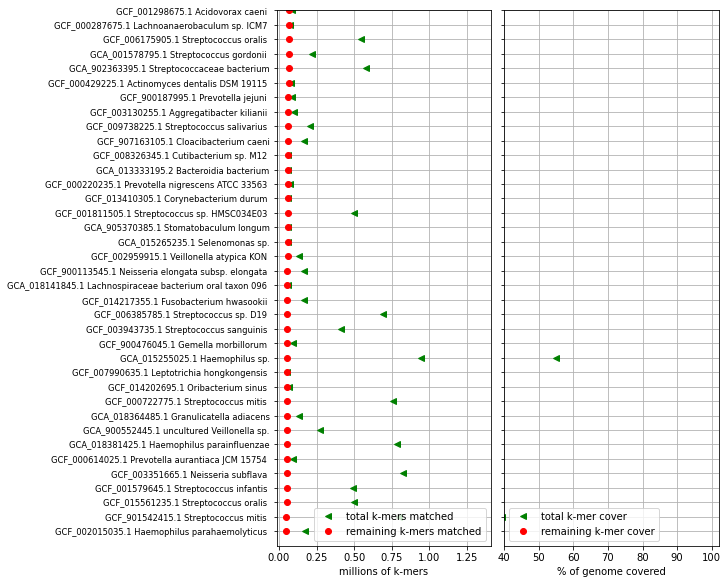

In [5]:
%matplotlib inline
import pylab

def gather_plot(gather_df):
    #Data clean-up
    gather_df = gatherDF_cleanUp(gather_df)
    
    #Plotting figure
    fig, (ax1, ax2) = pylab.subplots(1, 2, figsize=(10, 8), constrained_layout=True)
    SUBSAMPLE_TO = 36
    #pylab.plot(left_df.covered_bp / 1e6, left_df.iloc[::-1].index, 'b.', label='mapped bp to this genome')
    ax1.plot(gather_df.intersect_bp / 1e6, gather_df.iloc[::-1].index, 'g<',
             label='total k-mers matched')
    ax1.plot(gather_df.unique_intersect_bp / 1e6, gather_df.iloc[::-1].index, 'ro',
             label='remaining k-mers matched')

    positions = list(gather_df.index)
    labels = list(reversed(gather_df.Name))

    ax1.set_yticks(positions)
    ax1.set_yticklabels(labels, fontsize='small')

    ax1.set_xlabel('millions of k-mers')
    ax1.axis(ymin=-1, ymax=SUBSAMPLE_TO)
    ax1.legend(loc='lower right')
    ax1.grid(True, axis='both')

    ax2.plot(gather_df.f_match_orig * 100, gather_df.iloc[::-1].index, 'g<', label='total k-mer cover')
    ax2.plot(gather_df.f_match * 100, gather_df.iloc[::-1].index, 'ro', label='remaining k-mer cover')
    ax2.set_yticks(positions)
    ax2.set_yticklabels([])
    ax2.set_xlabel('% of genome covered')
    ax2.legend(loc='lower left')
    ax2.axis(xmin=40, xmax=102)
    ax2.axis(ymin=-1, ymax=SUBSAMPLE_TO)
    ax2.grid(True)

    #fig.tight_layout()
    #fig.savefig('fig2.svg')
    return
plot = gather_plot(sourmashGather_demoDF)

In [6]:
import glob
import os

# setting the path for joining multiple files
files = os.path.join("/home/kia/Desktop/DeepLearningMicrobiome/sourmash_resources/", "SRS*.sig.csv")

# list of merged files returned
files = glob.glob(files)

# joining files with concat and read_csv
combinedGather_df = pd.concat(map(pd.read_csv, files), ignore_index=True)
print(combinedGather_df.shape)
combinedGather_df.head()

(158775, 19)


,intersect_bp,f_orig_query,f_match,f_unique_to_query,f_unique_weighted,average_abund,median_abund,std_abund,name,filename,md5,f_match_orig,unique_intersect_bp,gather_result_rank,remaining_bp,query_filename,query_name,query_md5,query_bp
0,2220000,0.003756,0.708586,0.003756,0.003756,NaN,NaN,NaN,GCF_000185845.1 Prevotella salivae DSM 15606 s...,/mnt/HDD/kia/HMP_reference/gtdb-rs207.genomic-...,dff57ddcce4dd6b6a8940ac3baf34695,0.708586,2220000,0,152953000,NaN,SRS014470.tar.bz2,ecd0deaa,591117000
1,2207000,0.003734,0.742828,0.003679,0.003679,NaN,NaN,NaN,GCF_000613925.1 Prevotella histicola JCM 15637...,/mnt/HDD/kia/HMP_reference/gtdb-rs207.genomic-...,eacfb5d41d7cf4b700ce1526b366572b,0.753757,2175000,1,150778000,NaN,SRS014470.tar.bz2,ecd0deaa,591117000
2,2167000,0.003666,0.844176,0.003666,0.003666,NaN,NaN,NaN,GCF_002763915.1 Fusobacterium pseudoperiodonti...,/mnt/HDD/kia/HMP_reference/gtdb-rs207.genomic-...,721f0b8d1f9364b1922999b37caa723b,0.844176,2167000,2,148611000,NaN,SRS014470.tar.bz2,ecd0deaa,591117000
3,2134000,0.003610,0.693433,0.003608,0.003608,NaN,NaN,NaN,GCF_016651435.1 Catonella massiliensis strain=...,/mnt/HDD/kia/HMP_reference/gtdb-rs207.genomic-...,4ea84ca56b0eeafc7bda08311b978d26,0.693758,2133000,3,146478000,NaN,SRS014470.tar.bz2,ecd0deaa,591117000
4,2158000,0.003651,0.584906,0.003566,0.003566,NaN,NaN,NaN,GCF_900187995.1 Prevotella jejuni strain=DSM 2...,/mnt/HDD/kia/HMP_reference/gtdb-rs207.genomic-...,052d4e1d04265a0bb026713fab8042a8,0.598779,2108000,4,144370000,NaN,SRS014470.tar.bz2,ecd0deaa,591117000


In [7]:
combinedGather_df = combinedGather_df[combinedGather_df['f_match_orig'] > 0.90] # has to be a decimal ***bug***
print(combinedGather_df.shape)
combinedGather_df.head()

(511, 19)


,intersect_bp,f_orig_query,f_match,f_unique_to_query,f_unique_weighted,average_abund,median_abund,std_abund,name,filename,md5,f_match_orig,unique_intersect_bp,gather_result_rank,remaining_bp,query_filename,query_name,query_md5,query_bp
5,2003000,0.003389,0.917928,0.003387,0.003387,NaN,NaN,NaN,GCF_001074805.1 Streptococcus parasanguinis st...,/mnt/HDD/kia/HMP_reference/gtdb-rs207.genomic-...,6ccd3a1399547bdc639c88b30751963b,0.918386,2002000,5,142368000,NaN,SRS014470.tar.bz2,ecd0deaa,591117000
10,1836000,0.003106,0.921026,0.003098,0.003098,NaN,NaN,NaN,GCF_018128245.1 Leptotrichia sp. oral taxon 22...,/mnt/HDD/kia/HMP_reference/gtdb-rs207.genomic-...,d8657bac968309d44f44795b8c762ad5,0.923541,1831000,10,132969000,NaN,SRS014470.tar.bz2,ecd0deaa,591117000
22,1635000,0.002766,0.914121,0.002683,0.002683,NaN,NaN,NaN,GCF_013394695.1 Streptococcus sp. oral taxon 0...,/mnt/HDD/kia/HMP_reference/gtdb-rs207.genomic-...,13384302fbc67d015f8942c70f171b44,0.942363,1586000,22,112911000,NaN,SRS014470.tar.bz2,ecd0deaa,591117000
469,2425000,0.032423,0.954349,0.032423,0.032423,NaN,NaN,NaN,GCA_003243515.1 Corynebacterium kroppenstedtii...,/mnt/HDD/kia/HMP_reference/gtdb-rs207.genomic-...,49a5ff53d175fd9e116696b19f228318,0.954349,2425000,0,6472000,NaN,SRS019081.tar.bz2,49867db3,74792000
470,2304000,0.030805,0.975445,0.030805,0.030805,NaN,NaN,NaN,GCF_006742205.1 Staphylococcus epidermidis str...,/mnt/HDD/kia/HMP_reference/gtdb-rs207.genomic-...,573514f3d349904ef56eb74c28c247d7,0.975445,2304000,1,4168000,NaN,SRS019081.tar.bz2,49867db3,74792000


In [8]:
#Algorithm for getting tissue specific genera from GTDB database: 
#step 1: filter based on HMSAM.csv community (i.e..oral,gut,skin,vagina)
#step 2: Use those SRS ID's to filter combindedGather (which also contains GTDB Accession id's)
#step 3: Get the GTDB Accession ID's from filtered combindedGather and use those to filter MapBact2nameID.txt
#step 4: Use final list of GTDB Accession ID's from each environment and down select to most important bacteria
#        to have even amount of features for each environment

#Notes:
#---have to pick the most specific markers that do not show up in any other environment
#---this can be done by comparing lists of each env and removing bacteria that appear in the other environments
#---will have to extract only genomic.fna.gz from gtdb data base (it has a lot of )

### Creating List of Reference Genomes for Training CNN
Each metagenome produces 1 report that contains a list of reference genomes that can be used to identify its composition. After running the sourmash gather command on all of the 750 metagenomes, I then combined all of the reports to produce one large combined dataframe. I then filtered out the genomes that were <80% of a match to the original query so that we have higher quality reference for the training process. 

In [9]:
def fasta_ids(comm):
    #Purpose: to produce a dataframe that contains both Accession number and Genera/species names
    
    oral_df = HMP_df[HMP_df["Community"] == comm] # I had to create community column by myself through researching
    oral_df['SRS_ID'] = oral_df['SRS_ID'].astype(str)+'.tar.bz2'
    oral_SRS_ID = np.asarray(oral_df.SRS_ID).tolist()
    oral_accession_SRS = combinedGather_df[combinedGather_df['query_name'].isin(oral_SRS_ID)] # filters data frame by condition on specified column and given list
    oral_accession_SRS[['1','2', '3','4']] = combinedGather_df['name'].str.split(' ',3, expand=True)    
    oral_accession_SRS = oral_accession_SRS.drop(['4'], axis=1)
    oral_accession_SRS['Genera/Species'] = oral_accession_SRS['2']+ ' ' + oral_accession_SRS['3']
    oral_accession_SRS = oral_accession_SRS.drop(['2','3'], axis=1)
    oral_accession_SRS = oral_accession_SRS.rename(columns={'1':'Accession'})
    oral_accession_SRS[['Genera', 'Species']] = oral_accession_SRS['Genera/Species'].str.split(' ', expand=True)
    #oral_accession_SRS = oral_accession_SRS.drop_duplicates(['Genera']) # drops all duplicates in this column
    oral_accession_SRS = oral_accession_SRS.drop_duplicates(['Genera/Species'])
    oral_accession_SRS['Accession'] = oral_accession_SRS['Accession'] + '_genomic.fna.gz'
    tissue_specific_fasta_IDs = oral_accession_SRS[['Accession','Genera/Species']]

    return tissue_specific_fasta_IDs

tissue_specific_fasta_IDs_oral = fasta_ids('oral')
tissue_specific_fasta_IDs_skin = fasta_ids('skin')
tissue_specific_fasta_IDs_gut = fasta_ids('gut')
tissue_specific_fasta_IDs_vagina = fasta_ids('vagina')

/tmp/ipykernel_22139/3653262463.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oral_df['SRS_ID'] = oral_df['SRS_ID'].astype(str)+'.tar.bz2'
/home/kia/anaconda3/envs/tensorflow/lib/python3.9/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [10]:
with open("tissue_specific_fasta_IDs_vagina.txt", "w") as v:
    for i in tissue_specific_fasta_IDs_vagina['Accession']:
        v.write(i+"\n")
print(len(tissue_specific_fasta_IDs_vagina))
print(tissue_specific_fasta_IDs_vagina)

7
                            Accession            Genera/Species
1001   GCF_001436455.1_genomic.fna.gz    Lactobacillus jensenii
5285   GCF_000014425.1_genomic.fna.gz     Lactobacillus gasseri
10948  GCF_007095465.1_genomic.fna.gz    Lactobacillus mulieris
62521  GCA_900762445.1_genomic.fna.gz     uncultured Sutterella
68411  GCF_000025225.2_genomic.fna.gz  Mageeibacillus indolicus
68412  GCF_000214495.1_genomic.fna.gz           Megasphaera sp.
68418  GCA_902373515.1_genomic.fna.gz  uncultured Clostridiales


In [11]:
with open("tissue_specific_fasta_IDs_oral.txt", "w") as o:
    for i in tissue_specific_fasta_IDs_oral['Accession']:
        o.write(i+"\n")
print(len(tissue_specific_fasta_IDs_oral))
print(tissue_specific_fasta_IDs_oral)

38
                             Accession                       Genera/Species
5       GCF_001074805.1_genomic.fna.gz          Streptococcus parasanguinis
10      GCF_018128245.1_genomic.fna.gz                     Leptotrichia sp.
22      GCF_013394695.1_genomic.fna.gz                    Streptococcus sp.
747     GCF_000195595.1_genomic.fna.gz                      Actinomyces sp.
1376    GCF_902810435.1_genomic.fna.gz                  Veillonella parvula
2419    GCF_001956585.1_genomic.fna.gz               Actinomyces naeslundii
3242    GCF_003030305.1_genomic.fna.gz                  Cutibacterium acnes
7691    GCA_018127705.1_genomic.fna.gz                           TM7 phylum
10973   GCF_000227275.1_genomic.fna.gz                        Neisseria sp.
10984   GCA_013333875.2_genomic.fna.gz         Flavobacteriaceae bacterium,
11958   GCF_002386345.1_genomic.fna.gz                 Streptococcus oralis
13498   GCA_002355935.1_genomic.fna.gz                         Rothia aeria
15798   G

In [12]:
with open("tissue_specific_fasta_IDs_skin.txt", "w") as s:
    for i in tissue_specific_fasta_IDs_skin['Accession']:
        s.write(i+"\n")
print(len(tissue_specific_fasta_IDs_skin))
print(tissue_specific_fasta_IDs_skin)

6
                            Accession                   Genera/Species
469    GCA_003243515.1_genomic.fna.gz  Corynebacterium kroppenstedtii,
470    GCF_006742205.1_genomic.fna.gz       Staphylococcus epidermidis
2358   GCF_003030305.1_genomic.fna.gz              Cutibacterium acnes
2360   GCA_003241315.1_genomic.fna.gz       Lawsonella clevelandensis,
60080  GCF_900458815.1_genomic.fna.gz   Staphylococcus saccharolyticus
67845  GCF_002902325.1_genomic.fna.gz           Staphylococcus capitis


In [13]:
with open("tissue_specific_fasta_IDs_gut.txt", "w") as g:
    for i in tissue_specific_fasta_IDs_gut['Accession']:
        g.write(i+"\n")
print(len(tissue_specific_fasta_IDs_gut))
print(tissue_specific_fasta_IDs_gut)

64
                             Accession             Genera/Species
1043    GCA_900761145.1_genomic.fna.gz     uncultured Collinsella
1672    GCA_000980495.1_genomic.fna.gz          Acinetobacter sp.
2953    GCF_900106755.1_genomic.fna.gz         Bacteroides faecis
2977    GCA_900545135.1_genomic.fna.gz   uncultured Clostridiales
3715    GCA_900760735.1_genomic.fna.gz   Bacteroidales bacterium,
...                                ...                        ...
147215  GCF_013046825.1_genomic.fna.gz     Turicibacter sanguinis
149298  GCA_900760615.1_genomic.fna.gz   Lentisphaeria bacterium,
149363  GCA_000433035.1_genomic.fna.gz         Staphylococcus sp.
149492  GCA_900760795.1_genomic.fna.gz  Bacteroidaceae bacterium,
151422  GCF_000381365.1_genomic.fna.gz     Bacteroides salyersiae

[64 rows x 2 columns]


In [14]:
# Download GTDB database
#!wget https://data.gtdb.ecogenomic.org/releases/latest/genomic_files_reps/gtdb_genomes_reps.tar.gz

# Extracting only _genomic.fna.gz files from GTDB database (no directories)
# mkdir RefGenome; cd RefGenome
# tar -xzvf ../gtdb_genomes_reps.tar.gz --wildcards --no-anchored '*_genomic.fna.gz' --strip-components=5

In [15]:
### NOTE TO SELF:
'''
There are several cool pieces of information I realized: 
1. If you change the length of the nt slices you can get significantly higher accuracy, with minimal increase in 
computational expenditure
2. If the saliency maps work in opening up the black box of the CNN' we get unique insight on which kmer sequences 
are playing a role in classifying each environment 
3. We have a unique opportunity of modeling the slicing of the reference genome to the metagenomic processes. We can see the effect of
long reads vs short-read classification. What if we can a build a tool that also has the capability of modeling short vs long read
sequencing.

Summary: We can create a tool that can accomplish 3 things: 
1. find microbial composition strictly from metagenome seqs (no alignment/ clean-up necessary)
2. Have evolutionary insight based on kmer composition of sequencies (due to saliency maps)
3. freedom to adjust sequence length of interest. 
'''

"\nThere are several cool pieces of information I realized: \n1. If you change the length of the nt slices you can get significantly higher accuracy, with minimal increase in \ncomputational expenditure\n2. If the saliency maps work in opening up the black box of the CNN' we get unique insight on which kmer sequences \nare playing a role in classifying each environment \n3. We have a unique opportunity of modeling the slicing of the reference genome to the metagenomic processes. We can see the effect of\nlong reads vs short-read classification. What if we can a build a tool that also has the capability of modeling short vs long read\nsequencing.\n\nSummary: We can create a tool that can accomplish 3 things: \n1. find microbial composition strictly from metagenome seqs (no alignment/ clean-up necessary)\n2. Have evolutionary insight based on kmer composition of sequencies (due to saliency maps)\n3. freedom to adjust sequence length of interest. \n"

In [16]:
import gzip
import random
import pandas as pd
import re

nt = 500 # length of each sequence
Nseq = 40000 # number of randomly drawn chopped sequences from each fasta-file
random.seed(123) 
all_tissues_seqs = []
all_tissues_labs = []
for lab, tissue in enumerate(['oral', 'gut', 'skin', 'vagina']):
    
    print('Working with tissue: {} ************************************************'.format(tissue))
    fasta_df = pd.read_csv('tissue_specific_fasta_IDs_' + tissue + '.txt', header = None, sep = '\t')
    tissue_seqs = []
    for i in range(fasta_df.shape[0]):
        #print(fasta_df[0][i])
        
        with gzip.open('/home/kia/Desktop/DeepLearningMicrobiome/sourmash_resources/RefGenome/'
                       + fasta_df[0][i], 'rt') as f:
            content = f.read().splitlines(True)
            seq = ""
            
            #remove identifier, strip newline character, and join lines
            seq = ''.join(str(item.strip()) for item in content[1:])
            
            #add random sequences of varying lengths
            random_seqs = []
            for number in range(0, Nseq):#----------------------changed i to number
                rndint = random.randrange(0, (len(seq)-nt))
                random_seqs.append(seq[rndint:rndint+(nt)])
                   
            #random_seqs = random.sample(content, Nseq)
            #random_seqs = [j.rstrip()[0:nt] for j in random_seqs]
            random_seqs = [k for k in random_seqs if 
                           k.count('A') > 0 and k.count('C') > 0 and k.count('G') > 0 and k.count('T') > 0 
                           and len(list(k)) == nt and 'N' not in k and 'H' not in k and 'K' not in k 
                           and 'M' not in k and 'R' not in k and 'S' not in k and 'V' not in k 
                           and 'W' not in k and 'Y' not in k and 'B' not in k]
            #random_seqs = re.sub('[^ATCG]', '', random_seqs)
            tissue_seqs += random_seqs
            tissue_seqs = list(filter(lambda v: re.match('^[AGCT]+$', v), tissue_seqs)) # gets rid of any unwanted characters in tissue_seqs
            
            if((i + 1) % 500 == 0):
                print('Finished {} fasta-files'.format(i + 1))
         
    all_tissues_seqs += tissue_seqs
    # Filtering list based on lines that do contain any characters other than ATGC ($ signals end of string + means any character that matches)
    #all_tissues_seqs = list(filter(lambda v: re.match('^[AGCT]+$', v), all_tissues_seqs))
    
    print(all_tissues_seqs[(len(all_tissues_seqs)-3):len(all_tissues_seqs)])
    all_tissues_labs = all_tissues_labs + [lab]*len(tissue_seqs)
    print(all_tissues_labs[(len(all_tissues_labs)-3):len(all_tissues_labs)])

Working with tissue: oral ************************************************
['ATGTTGGAGAAATGGTAGAGGCACGTGTTACGTTCAAACGTGAAGATGGTCGTATTAATGTGTCAATGCGTCCAATTAAAGAAAAAGCGTTAATCTCTGATGGTCAGATTATTATGGAATACCTATTACAACGAGGCGGTAAAATGCCTTATAGTGATGAGTCATCAGCCATGTTGATTAAGGATAAATTTAACATCAGCAAGGCTGCTTTTAAACGAGCGTTAGGTCATTTAATGAAATCCCGCCTTGTAGTACAAGAAGATGGTTGGACATTGTTGACAGAAACTGGTAAACAATGGACCTCAAATTCACAAGAGGTCTAAACTATGAAGATTATTGTAGTAGGTGCTGGTAAGGTTGGGTATTCCTTGTGTGAAAGATTGGTGCAAGATGATCATGACGTATATCTTATAGACCGTTCACAGGAGCGTATCCATAATCTTGAAAACACATTGGATGTTAGTTTAGTATGCGGTAATGGTAGCGATATTCAGTTATTG', 'CAAGAGCTTGTTTCCAGTTTGCATCTTCAAAGAAGATATTTGCCGATTTACCACCTAATTCCAATGTAGCAGGAATCAAGCGTTCAGATGCCGCTTTATATACATCAAGACCTACTTCTGTAGAGCCTGTGAAAGCAAGTTTGCTAAATCCAGGATGATCAAGGATATATTGTCCAGATTTAGAGCCTTTACCAGTTACAATGTTTACAACACCTGGAGGCAAGATATCTTGCAAAATACTACCTAGTTCTAATAGACTAAGGGATGTATGGCTAGAAGGTTTGATAACAACTGTACACCCTGCTGCCAGCGCTGGTGCCAATTTCCAAGCAGCCATTAAGAATGGGAAGTTCCAAGGTACTACTTGACCTACTACGCCAATCGGTTCACGAATAATAAGACTTAATGTATTTTCATCA

In [17]:
len(all_tissues_seqs)

4499976

In [18]:
len(all_tissues_labs)

4499976

In [19]:
import numpy as np
characters = [list(i) for i in all_tissues_seqs]
set(np.ndarray.flatten(np.array(characters)))

{'A', 'C', 'G', 'T'}

In [20]:
set(all_tissues_labs)

{0, 1, 2, 3}

In [21]:
from collections import Counter
Counter(all_tissues_labs)

Counter({0: 1495278, 1: 2490715, 2: 237966, 3: 276017})

In [22]:
import pandas as pd
df = pd.DataFrame({'SEQ': all_tissues_seqs, 'LAB': all_tissues_labs})
df

,SEQ,LAB
0,AATAGCCGGTCTGGCAAGCAACTCAAGGCCTATTATAAAAATGGCA...,0
1,ATCTTTCCTTCTGGTGTTAAAACACTTGGCGCTTGCTGAGCAATCT...,0
2,AGAGCATGCAAGTATAGAAGTTTAAAAGAATAAGGCTTGAAACAAT...,0
3,TAATCCAGCTGATTGGTTTAAACCTTACCAAGAAGTTCTTTCACGT...,0
4,TTTCTGTCATTTCACTCTTGTCTCTTATTGTATTGTCGTTTTCCTC...,0
...,...,...
4499971,ACACGTCGCTGGCATTCATCAAGTATTCCGCCACCGTTACACGATA...,3
4499972,TTAATAATCCGCTTGCCACGATAAATATAACCTTTTTCGTAATATT...,3
4499973,AACAACAGGTTCAACATGATGGTCATCAAAATTAGGCCGGAAATCA...,3
4499974,CAGGGTGTTCTTGCCGGCGAACTTTTCGATTTGGCGGCGGAAGATC...,3


In [23]:
N = 200000 # used this number because this is the minimum count of the labels and tissues
df_all_tissues = pd.concat([df[df['LAB'] == 0].sample(N), df[df['LAB'] == 1].sample(N), 
                            df[df['LAB'] == 2].sample(N), df[df['LAB'] == 3].sample(N)])
df_all_tissues

,SEQ,LAB
87919,TAATCCAACTGCTATTTCAGCGCCAACTGCAACTCTACCATATATT...,0
1035494,GCCTTCAAGGCAAGTGCTCTTGACTTTTATTTATATCTTACACATT...,0
625196,GGTGTGTTATCAGGTGAAGTAGCCTTTAAACTTTATGATACTTATG...,0
1391633,ACACGTGGAATTCTACCCCTCCCTAAAGTACTCTAGACCCCCAGTC...,0
1321754,AAAAGCGTTAGTTAATGATACTCAAGAATGTTCTTGGGAAGAGTTG...,0
...,...,...
4392394,TACCTTTTTCTTGGGTGGAGTTTCTGCTGCCATCGCAGGGGCACTT...,3
4437006,AACGGGCACATATTTCCCTGCCTAAGACGGAACAGTCGCCGCAGGA...,3
4370996,CAAGCGGCGTGCCGCCTGACGCTTCCCAGGCGTGGCAAAGACGCCC...,3
4446164,CATAGCCGCTACTATTCGGAATATGATCAAAATTCGATATTACAGA...,3


In [24]:
all_tissues_seqs = list(df_all_tissues['SEQ'])
all_tissues_labs = list(df_all_tissues['LAB'])

In [25]:
from collections import Counter
Counter(all_tissues_labs)

Counter({0: 200000, 1: 200000, 2: 200000, 3: 200000})

In [26]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# The LabelEncoder encodes a sequence of bases as a sequence of integers: 0, 1, 2 and 3
integer_encoder = LabelEncoder()  
# The OneHotEncoder converts an array of integers to a sparse matrix where 
# each row corresponds to one possible value of each feature, i.e. only 0 and 1 are present in the matrix
one_hot_encoder = OneHotEncoder()   
input_features = []

for sequence in all_tissues_seqs:
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  input_features.append(one_hot_encoded.toarray())

np.set_printoptions(threshold = 40)
input_features = np.stack(input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',all_tissues_seqs[0][:10],'...',all_tissues_seqs[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)

Example sequence
-----------------------
DNA Sequence #1:
 TAATCCAACT ... GCAGATAACG
One hot encoding of Sequence #1:
 [[0. 1. 1. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]]


In [27]:
one_hot_encoder = OneHotEncoder()
labels = np.array(all_tissues_labs).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

print('Labels:\n',labels.T)
print('One-hot encoded labels:\n',input_labels.T)

Labels:
 [[0 0 0 ... 3 3 3]]
One-hot encoded labels:
 [[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 1. 1.]]


In [28]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(input_features, input_labels, 
                                                                            test_size = 0.25, random_state = 42)

In [29]:
train_features.shape

(600000, 500, 4)

In [30]:
test_features.shape

(200000, 500, 4)

In [31]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Conv1D(filters = 512, kernel_size = 20, input_shape = (train_features.shape[1], 4), 
                 padding = 'same', activation = 'relu'))
#model.add(MaxPooling1D(pool_size = 2))
#model.add(Dropout(0.3))
#model.add(Conv1D(filters = 512, kernel_size = 10, padding = 'same', activation = 'relu'))
model.add(MaxPooling1D(pool_size = 2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(4, activation = 'softmax'))

epochs = 10
lrate = 0.01
decay = lrate / epochs
sgd = SGD(lr = lrate, momentum = 0.9, decay = decay, nesterov = False)
model.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 500, 512)          41472     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 250, 512)          0         
_________________________________________________________________
dropout (Dropout)            (None, 250, 512)          0         
_________________________________________________________________
flatten (Flatten)            (None, 128000)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               32768256  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1

2022-07-28 02:44:52.396813: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-28 02:44:52.396988: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-28 02:44:52.398362: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [32]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

filepath = "weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'max')
rlrp = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.1, patience = 5, verbose = 1, min_lr = 0.0001)

history = model.fit(train_features, train_labels, epochs = epochs, verbose = 1, validation_split = 0.25,
                   batch_size = 32, shuffle = True, callbacks = [rlrp, checkpoint])

2022-07-28 02:44:55.088427: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-07-28 02:44:55.109147: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3000000000 Hz


Epoch 1/10
14063/14063 [==============================] - 1425s 101ms/step - loss: 1.1309 - accuracy: 0.4755 - val_loss: 0.8016 - val_accuracy: 0.6750

Epoch 00001: val_accuracy improved from -inf to 0.67503, saving model to weights.best.hdf5
Epoch 2/10
14063/14063 [==============================] - 1436s 102ms/step - loss: 0.7790 - accuracy: 0.6882 - val_loss: 0.7305 - val_accuracy: 0.7138

Epoch 00002: val_accuracy improved from 0.67503 to 0.71383, saving model to weights.best.hdf5
Epoch 3/10
14063/14063 [==============================] - 1448s 103ms/step - loss: 0.7007 - accuracy: 0.7282 - val_loss: 0.7125 - val_accuracy: 0.7207

Epoch 00003: val_accuracy improved from 0.71383 to 0.72073, saving model to weights.best.hdf5
Epoch 4/10
14063/14063 [==============================] - 1450s 103ms/step - loss: 0.6536 - accuracy: 0.7503 - val_loss: 0.6925 - val_accuracy: 0.7329

Epoch 00004: val_accuracy improved from 0.72073 to 0.73292, saving model to weights.best.hdf5
Epoch 5/10
14063/14

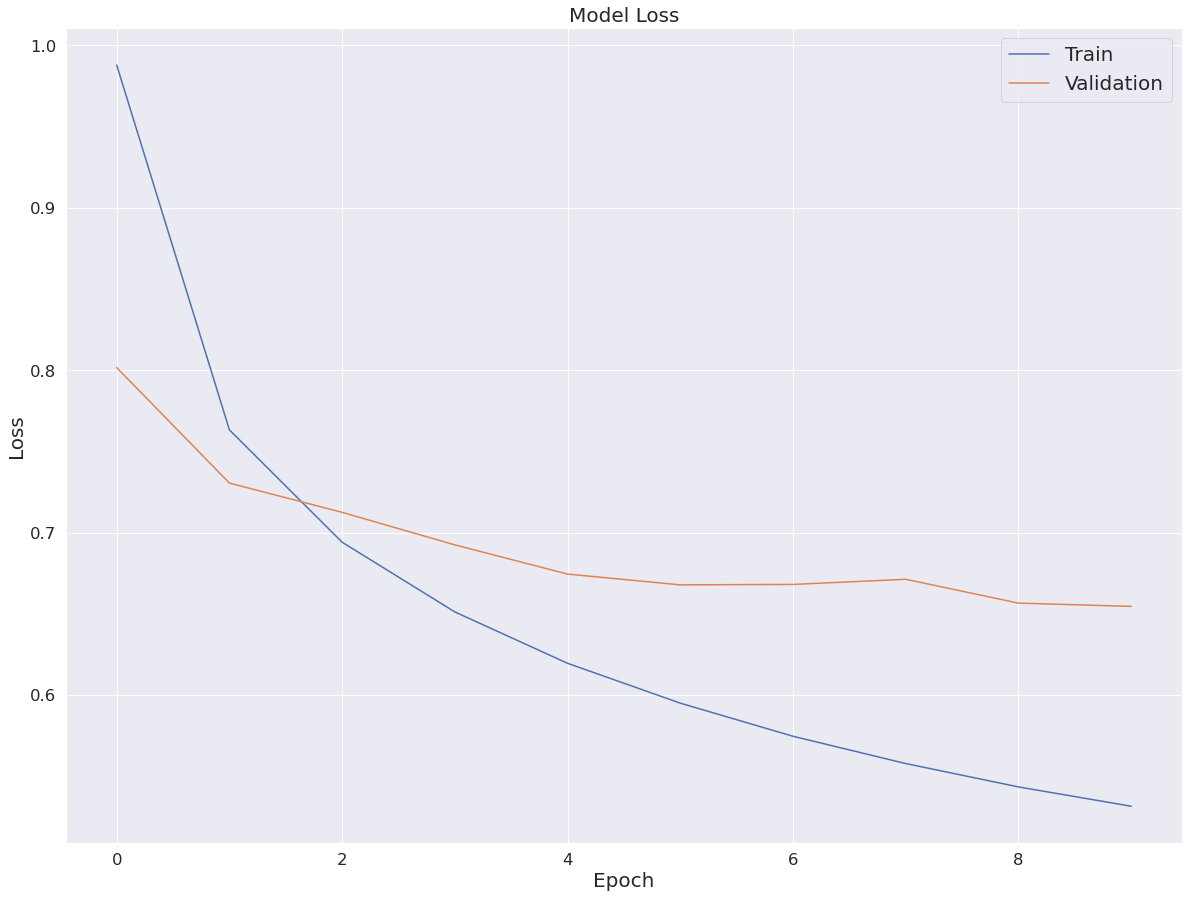

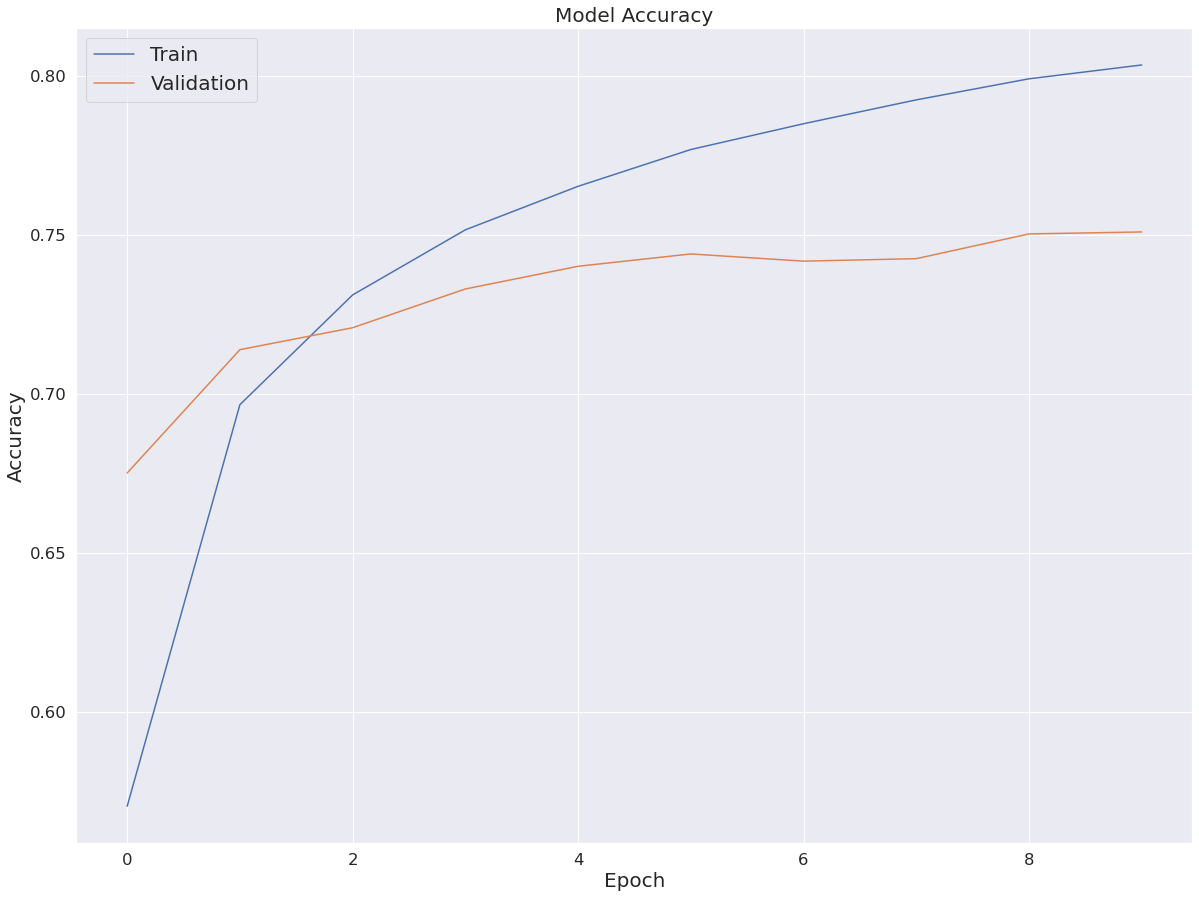

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale = 1.5)

plt.figure(figsize = (20,15))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()

plt.figure(figsize = (20,15))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()

In [34]:
## Switching length of nucleotide to from 80nt to 300
### this should switch accuracy from 44% TO 65%
### 300 nt -> 500nt = 65% to 75%

In [35]:
model.save('DeepLearningMicrobiome.h5')

In [36]:
from tensorflow import keras
model = keras.models.load_model('DeepLearningMicrobiome.h5')

Confusion matrix:
 [[31496  6073  7796  4454]
 [ 5304 38170  3794  2977]
 [ 3181  1708 43496  1581]
 [ 5300  4473  3125 37072]]


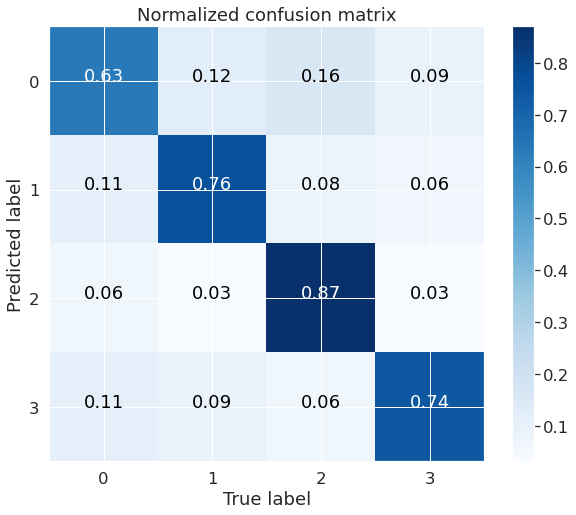

In [37]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale = 1.5)

from sklearn.metrics import confusion_matrix
import itertools

plt.figure(figsize = (10,8))

predicted_labels = model.predict(np.stack(test_features))
cm = confusion_matrix(np.argmax(test_labels, axis = 1), np.argmax(predicted_labels, axis = 1))
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap = plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1, 2, 3]); plt.yticks([0, 1, 2, 3])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment = 'center',
             color = 'white' if cm[i, j] > 0.5 else 'black')
plt.show()

In [ ]:
print("this is terrible and hard and I don't want to do this anymore")